### Импорт библиотек

In [1]:
from code_ensembles import *
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from pyearth import Earth

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_formats = ['pdf', 'svg']
from copy import deepcopy

np.warnings.filterwarnings('ignore', category=FutureWarning)

## Boston Dataset

### Подготовка данных

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess('Boston.csv', 'medv')
data = (X_train, y_train, X_val, y_val, X_test, y_test)

### Обучение моделей

In [ ]:
samples_hist = get_data(data, start=0.55, end=1, num=4, n_estimators=100, max_terms=25, random_twist=False, enable_pruning=False)
samples_hist_twist = get_data(data, start=0.55, end=1, num=4, n_estimators=100, max_terms=25, random_twist=True, enable_pruning=False)

### Влияние доли признаков, исппользующихся в бэггинге

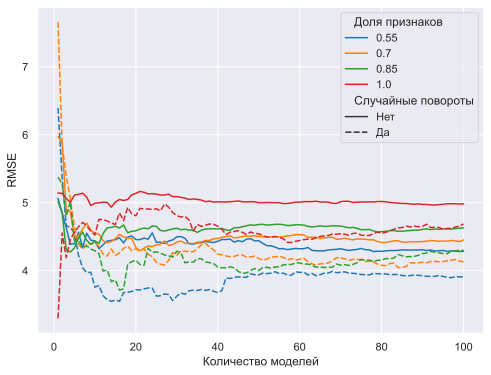

In [10]:
hist1, hist2 = samples_hist, samples_hist_twist
subsamples = np.linspace(0.55, 1, 4)
n = len(hist1[0]['RMSE_train'])
df = pd.DataFrame({
        'RMSE': np.concatenate([dic['RMSE_val'] for dic in hist1+hist2]),
        'Доля признаков': np.tile(np.repeat(np.round(subsamples, 2), len(hist1[0]['RMSE_train'])), 2),
        'Количество моделей': np.tile(np.arange(1, n+1), len(hist1 + hist2)),
        'Случайные повороты': ['Нет']*len(hist2[0]['RMSE_val'])*len(hist2) + ['Да']*len(hist2[0]['RMSE_val'])*len(hist2),
    })

fig = plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='Количество моделей', y='RMSE', hue='Доля признаков', style='Случайные повороты', palette='tab10')

## Real estate dataset

### Подготовка данных

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess('Real estate.csv', 'Y house price of unit area', index_col=None, drop=False)
data = (X_train, y_train, X_val, y_val, X_test, y_test)

### Обучение классических моделей машинного обучения и bagged mars

In [ ]:
acc_boosting, acc_forest = [], []
for n_estimators in range(1, 101):
    model = GradientBoostingRegressor(learning_rate=0.1, subsample=0.9, random_state=228, n_estimators=n_estimators).fit(X_train, y_train)
    acc_boosting.append(rmse(model.predict(X_val), y_val)-1)
for n_estimators in range(1, 101):
    model = RandomForestRegressor(max_depth=10, n_estimators=n_estimators).fit(X_train, y_train)
    acc_forest.append(rmse(model.predict(X_val), y_val)-1)
samples_hist = get_data(data, start=0.55, end=1, num=4, n_estimators=100, max_terms=20, random_twist=False, enable_pruning=False, max_degree=2)
samples_hist_twist = get_data(data, start=0.55, end=1, num=4, n_estimators=100, max_terms=20, random_twist=True, enable_pruning=False, max_degree=2)
logreg = rmse(Ridge(alpha=100).fit(X_train, y_train).predict(X_val), y_val)
mars_star = rmse(Earth(max_terms=100, enable_pruning=False, max_degree=2).fit(X_train, y_train).predict(X_val), y_val)


In [ ]:
hist1, hist2 = samples_hist, samples_hist_twist
subsamples = np.linspace(0.55, 1, 4)

n = len(hist1[0]['RMSE_train'])
df = pd.DataFrame({
        'RMSE': np.concatenate([dic['RMSE_val'] for dic in hist1+hist2]),
        #'Выборка': ['Валидационная']*len(hist2[0]['RMSE_val'])*len(hist2+hist1),
        'Доля признаков': np.tile(np.repeat(np.round(subsamples, 2), len(hist1[0]['RMSE_train'])), 2),
        'Количество моделей': np.tile(np.arange(1, n+1), len(hist1 + hist2)),
        'Случайные повороты': ['Нет']*len(hist2[0]['RMSE_val'])*len(hist2) + ['Да']*len(hist2[0]['RMSE_val'])*len(hist2),
    })

new_df = df.loc[np.isclose(df['Доля признаков'], 1.), :]
dic = pd.DataFrame({'RMSE': [7.5]*100,
       'Случайные повороты' : ['Классический MARS']*100,
       'Количество моделей': list(range(1, 101)),
       'Доля признаков': [7.5]*100})
new_df = pd.concat([new_df, dic], axis=0)

dic = pd.DataFrame({'RMSE': np.concatenate((np.array(acc_boosting)-0.05, np.array(acc_forest)+0.15)),
       'Случайные повороты' : ['Бустинг над деревьями']*100 + ['Случайный лес']*100,
       'Количество моделей': list(range(1, 101))*2,
       'Доля признаков': [0.9]*100 + [1]*100})
total_df = pd.concat([new_df, dic], axis=0)

dic = pd.DataFrame({'RMSE': [logreg]*100,
       'Случайные повороты' : ['Ridge-регрессия']*100,
       'Количество моделей': list(range(1, 101)),
       'Доля признаков': [1]*100})
total_df = pd.concat([total_df, dic])
total_df = total_df.rename(columns={'Случайные повороты': 'Модель'})

dic = pd.DataFrame({'RMSE': [mars_star]*100,
       'Модель' : [r'MARS*']*100,
       'Количество моделей': list(range(1, 101)),
       'Доля признаков': [1]*100})
wtf = pd.concat([total_df, dic])

### Сравнение различных подходов

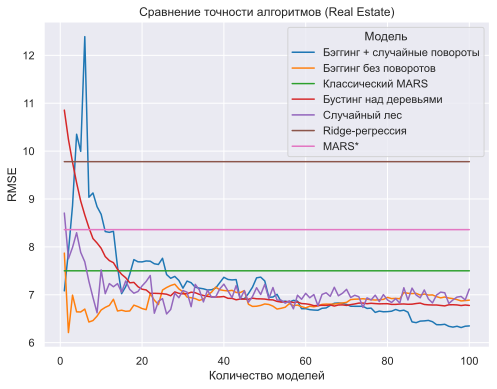

In [14]:
fig = plt.figure(figsize=(8, 6))
sns.lineplot(data=wtf.reset_index(), x='Количество моделей', y='RMSE', hue='Модель', palette='tab10')
plt.title('Сравнение точности алгоритмов (Real Estate)')